Number of rollouts: 50
Average WebShopreward: 0.4267
Average evaluator reward: 0.5773
Number of perfect rollouts: 6
Number of rollouts that did not get completed in 50 steps: 13
Number of completed rollouts: 37
	Average WebShop reward for completed rollouts: 0.5766
	Average evaluator reward for completed rollouts: 0.7802


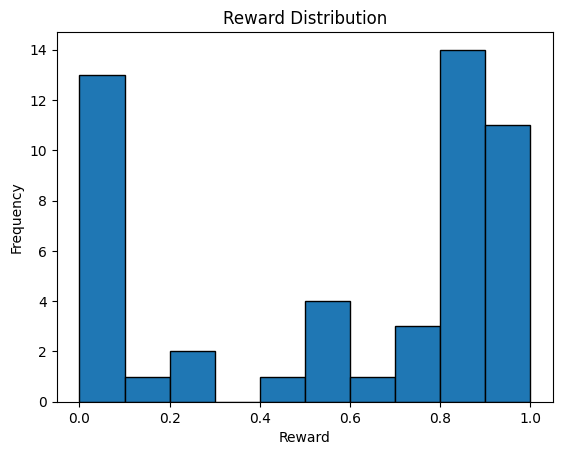

In [11]:
import os
import json
import random
import matplotlib.pyplot as plt
import numpy as np

experiments_dir = 'experiments/interactive_rollouts'

experiment_name = 'claude3.7_v2sim_v3scenarios-50tasks-50maxsteps'

file_path = os.path.join(experiments_dir, f"{experiment_name}.json")
with open(file_path, 'r') as f:
    data = json.load(f)

print(f"Number of rollouts: {len(data['rollouts'])}")
print(f"Average WebShopreward: {data['avg_reward']:.4f}")
print(f"Average evaluator reward: {np.mean([rollout['evaluator_reward'] for rollout in data['rollouts']]):.4f}")
print(f"Number of perfect rollouts: {data['num_perfect_rollouts']}")
print(f"Number of rollouts that did not get completed in 50 steps: {len(data['rollouts']) - data['num_task_completed_rollouts']}")

# average evaluator reward for completed rollouts
completed_rollouts = [rollout for rollout in data['rollouts'] if rollout['info']['task_completed']]
print(f"Number of completed rollouts: {len(completed_rollouts)}")
print(f"\tAverage WebShop reward for completed rollouts: {np.mean([rollout['reward'] for rollout in completed_rollouts]):.4f}")
print(f"\tAverage evaluator reward for completed rollouts: {np.mean([rollout['evaluator_reward'] for rollout in completed_rollouts]):.4f}")

# Plot the reward distribution
reward_distribution = [rollout['evaluator_reward'] for rollout in data['rollouts']]
plt.hist(reward_distribution, bins=10, edgecolor='black')
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

In [12]:
[(rollout['evaluator_reward'], rollout['info']['num_user_utterances']) for rollout in data['rollouts'] if rollout['info']['task_completed']]

[(0.8333333333333334, 9),
 (0.5, 1),
 (0.8571428571428571, 2),
 (0.8, 1),
 (1.0, 5),
 (0.8571428571428571, 2),
 (0.4, 2),
 (0.8571428571428571, 4),
 (0.8571428571428571, 4),
 (0.8, 6),
 (1.0, 6),
 (0.8, 1),
 (1.0, 3),
 (0.6666666666666666, 8),
 (0.75, 1),
 (0.2857142857142857, 1),
 (0.16666666666666666, 1),
 (0.8571428571428571, 1),
 (0.2857142857142857, 14),
 (0.8571428571428571, 5),
 (0.6, 1),
 (1.0, 1),
 (0.7142857142857143, 2),
 (0.8333333333333334, 10),
 (1.0, 3),
 (0.5714285714285714, 1),
 (1.0, 4),
 (1.0, 3),
 (1.0, 5),
 (0.8333333333333334, 5),
 (0.5, 1),
 (0.75, 4),
 (1.0, 6),
 (0.8333333333333334, 8),
 (1.0, 2),
 (0.8, 1),
 (1.0, 4)]

Number of rollouts with 1 user utterance: 12
Average reward of no dialog rollouts: 0.6359


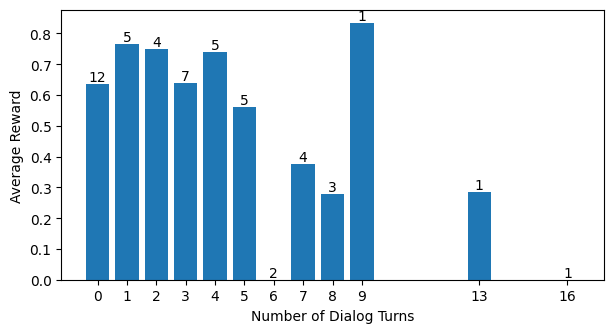

In [13]:
from collections import defaultdict
import numpy as np

# find number of rollouts that have 1 user utterance
no_dialog_rollouts = [rollout for rollout in data['rollouts'] if rollout['info']['num_user_utterances'] == 1]
print(f"Number of rollouts with 1 user utterance: {len(no_dialog_rollouts)}")

# Find average reward of no dialog rollouts
no_dialog_reward = sum([rollout['evaluator_reward'] for rollout in no_dialog_rollouts]) / len(no_dialog_rollouts)
print(f"Average reward of no dialog rollouts: {no_dialog_reward:.4f}")

# Make bar plot of number of user utterances vs average reward for rollouts with those many user utterance
avg_reward_per_num_utterances = defaultdict(list)
for rollout in data['rollouts']:
    avg_reward_per_num_utterances[rollout['info']['num_user_utterances']-1].append(rollout['evaluator_reward'])

fig, ax = plt.subplots(figsize=(7, 3.5))
# Plot the bar plot, with number of rollouts written on the top of each bar
plt.bar(
    avg_reward_per_num_utterances.keys(), 
    [sum(rewards) / len(rewards) for rewards in avg_reward_per_num_utterances.values()], 
    # yerr=[np.std(rewards) for rewards in avg_reward_per_num_utterances.values()]
)
for num_utterances in avg_reward_per_num_utterances.keys():
    plt.text(
        num_utterances, 
        sum(avg_reward_per_num_utterances[num_utterances]) / len(avg_reward_per_num_utterances[num_utterances]), 
        f'{len(avg_reward_per_num_utterances[num_utterances])}', 
    ha='center', va='bottom'
    )
plt.xlabel('Number of Dialog Turns')
plt.ylabel('Average Reward')
plt.xticks(list(avg_reward_per_num_utterances.keys()))
plt.show()


In [8]:
rollout = random.choice(data['rollouts'])
print(f"Scenario ID: {rollout['scenario']['scenario_id']}")
print(f"\tInitial (goal) product ASIN: {rollout['scenario']['asin']}")
print(f"\tScenario: {rollout['scenario']['instruction_text']}")
print(f"\tProduct type: {rollout['scenario']['product_type']}")
# print(f"\tAttributes: {', '.join(rollout['scenario']['attributes'])}")
print("\tAttributes:\n\t  " + rollout['scenario']['attribute_wise_reasoning'].replace('\n', '\n\t  '))
print(f"\tOptions: {', '.join([f'{k}: {v}' for k, v in rollout['scenario']['goal_options_dict'].items()])}")
print(f"\tBudget: ${rollout['scenario']['price_upper']}")
print(f"\nTrajectory:")
for t in rollout['trajectory']:
    if 'ENVIRONMENT OBSERVATION' in t['content']:
        continue
    if 'ACTION:' in t['content']:
        print("> AGENT: " + t['content'].split('ACTION:')[1].strip())
    else:
        print("> USER: " + t['content'].split('USER RESPONSE:')[-1].strip())

print(f"\nNumber of user utterances: {rollout['info']['num_user_utterances']}")
print(f"Number of agent actions in env: {rollout['info']['num_environment_steps']}")
print(f"Total LLM cost: ${rollout['info']['total_llm_cost']:.2f}")
print(f"\nPurchased product:")
print(f"\tASIN: {rollout['info']['purchased_item']['asin']}")
print(f"\tName: {rollout['info']['purchased_item']['product_name']}")
print(f"\tAttributes: {', '.join(rollout['info']['purchased_item']['attributes'])}")
print("\tOptions: \n" + '\n'.join([f'\t- {k}: {v}' for k, v in rollout['info']['purchased_item']['options'].items()]))
print(f"\tPrice: {rollout['info']['purchased_item']['price']}")
print(f"Environment reward: {rollout['reward']:.4f}")
print(f"Evaluator reward: {rollout['evaluator_reward']:.4f}")
print(f"\tr_type: {rollout['info']['evaluator_results']['r_type']}")
print(f"\tr_attr: {rollout['info']['evaluator_results']['r_attr']} ({rollout['info']['evaluator_results']['attr_scores']})")
print(f"\tr_option: {rollout['info']['evaluator_results']['r_option']} ({rollout['info']['evaluator_results']['option_scores']})")
print(f"\tr_price: {rollout['info']['evaluator_results']['r_price']}")



Scenario ID: electronics000
	Initial (goal) product ASIN: B09N92JSCP
	Scenario: You recently bought a new Apple smartwatch and, since you are always on the go and sometimes bump your wrist against hard surfaces, you want to keep your watch protected without adding extra bulk or changing how it looks, so you decide to buy a smartwatch case designed for your model.
	Product type: smartwatch case
	Attributes:
	  - screen protector: You need to guard the screen from scratches and impacts that happen during your busy daily activities.
	  - tempered glass: You want strong protection that can absorb shocks and prevent cracks if you accidentally hit or drop your watch.
	  - easy install: You prefer a hassle-free setup so you can start using your watch and protection right away, without complicated tools or procedures.
	  - compatible apple: You have an Apple smartwatch and want a case that fits perfectly and doesn't interfere with its features or buttons.
	Options: color: clear, size: 41mm
	Bu

In [ ]:
from pprint import pprint
for t in rollout['trajectory']:
    pprint(t)


In [ ]:
pprint(rollout['info']['purchased_item'])

In [ ]:
class Args:
    def __init__(self, secrets_file: str):
        self.secrets_file = secrets_file
args = Args('../secrets.yaml')
model_name = 'claude-3-7-sonnet-latest'
from eval_utils import WebShopLMEvaluator

evaluator = WebShopLMEvaluator(model_name, args)

rollout = random.choice(data['rollouts'])

print("\Goal:")
print(f"Scenario ID: {rollout['scenario']['scenario_id']}")
print(f"Scenario: {rollout['scenario']['instruction_text']}")
print(f"\tProduct type: {rollout['scenario']['product_type']}")
print(f"\tAttributes: {', '.join(rollout['scenario']['attributes'])}")
print(f"\tOptions: {', '.join(rollout['scenario']['goal_options'])}")
print(f"\tBudget: ${rollout['scenario']['price_upper']}")


print("\nPurchased product:")
print(f"\tASIN: {rollout['info']['purchased_item']['asin']}")
print(f"\tName: {rollout['info']['purchased_item']['product_name']}")
print(f"\tAttributes: {', '.join(rollout['info']['purchased_item']['attributes'])}")
print("\tOptions: \n" + '\n'.join([f'\t- {k}: {v}' for k, v in rollout['info']['purchased_item']['options'].items()]))
print(f"\tPrice: {rollout['info']['purchased_item']['price']}")

rollout['evaluator_results'] = evaluator.evaluate(rollout['info']['purchased_item'], rollout['scenario'])
print(f"{rollout['scenario']['scenario_id']}: {rollout['reward']:.4f} -> {rollout['evaluator_results']['total_reward']:.4f}")
print("\tr_type: ", rollout['evaluator_results']['r_type'])
print("\tr_attr: ", rollout['evaluator_results']['r_attr'], f"({rollout['evaluator_results']['attr_scores']})")
print("\tr_option: ", rollout['evaluator_results']['r_option'], f"({rollout['evaluator_results']['option_scores']})")
print("\tr_price: ", rollout['evaluator_results']['r_price'])
print("\ttotal_reward: ", rollout['evaluator_results']['total_reward'])


In [ ]:
from tqdm import tqdm

evaluator = WebShopLMEvaluator(model_name, args)
all_evaluator_results = []
for rollout in tqdm(data['rollouts']):
    if 'purchased_item' not in rollout['info']:
        continue
    scenario_id = rollout['scenario']['scenario_id']
    original_reward = rollout['reward']
    evaluator_results = evaluator.evaluate(rollout['info']['purchased_item'], rollout['scenario'])
    new_reward = evaluator_results['total_reward']
    all_evaluator_results.append({
        'scenario_id': scenario_id,
        'original_reward': original_reward,
        'new_reward': new_reward,
        'evaluator_results': evaluator_results,
    })
print(f"Mean original reward: {sum([r['original_reward'] for r in all_evaluator_results]) / len(all_evaluator_results):.4f}")
print(f"Mean new reward: {sum([r['new_reward'] for r in all_evaluator_results]) / len(all_evaluator_results):.4f}")
print(f"Mean improvement: {sum([r['new_reward'] - r['original_reward'] for r in all_evaluator_results]) / len(all_evaluator_results):.4f}")
print(f"Number of improved rewards: {sum([r['new_reward'] > r['original_reward'] for r in all_evaluator_results])}")
print(f"Number of worsened rewards: {sum([r['new_reward'] < r['original_reward'] for r in all_evaluator_results])}")
print(f"Total LLM cost: ${evaluator.llm_cost:.2f} (average: {evaluator.llm_cost / evaluator.num_evaluations:.2f})")
